# Time Series Forecasting using Pytorch

Time series forecasting plays a major role in data analysis, with applications ranging from anticipating stock market trends to forecasting weather patterns. In this article, we’ll dive into the field of time series forecasting using PyTorch and LSTM (Long Short-Term Memory) neural networks. We’ll uncover the critical preprocessing procedures that underpin the accuracy of our forecasts along the way.

This notebook is largely based on 
Source: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/



In [1]:
# you may have to install the yfinance package
!pip install yfinance

## Step 1: The usual imports

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchmetrics import MeanAbsoluteError
from utils import train_model

sns.set_theme()

## Step 2: Load the Dataset

In this step, we are using ‘yfinance’ library to download historical stock market data for Apple Inc. (AAPL) from Yahoo Finance.

In [3]:
stock_ticker = 'NVDA'
 
import yfinance as yf
from datetime import date, timedelta, datetime 
 
end_date =  date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date 
start_date = '1990-01-01' # Beginning date for our historical data retrieval 
 
df = yf.download(stock_ticker, start=start_date, end=end_date)# Function used to fetch the data 

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000


## Step 3: Data Preprocessing

### Plot the time series trend

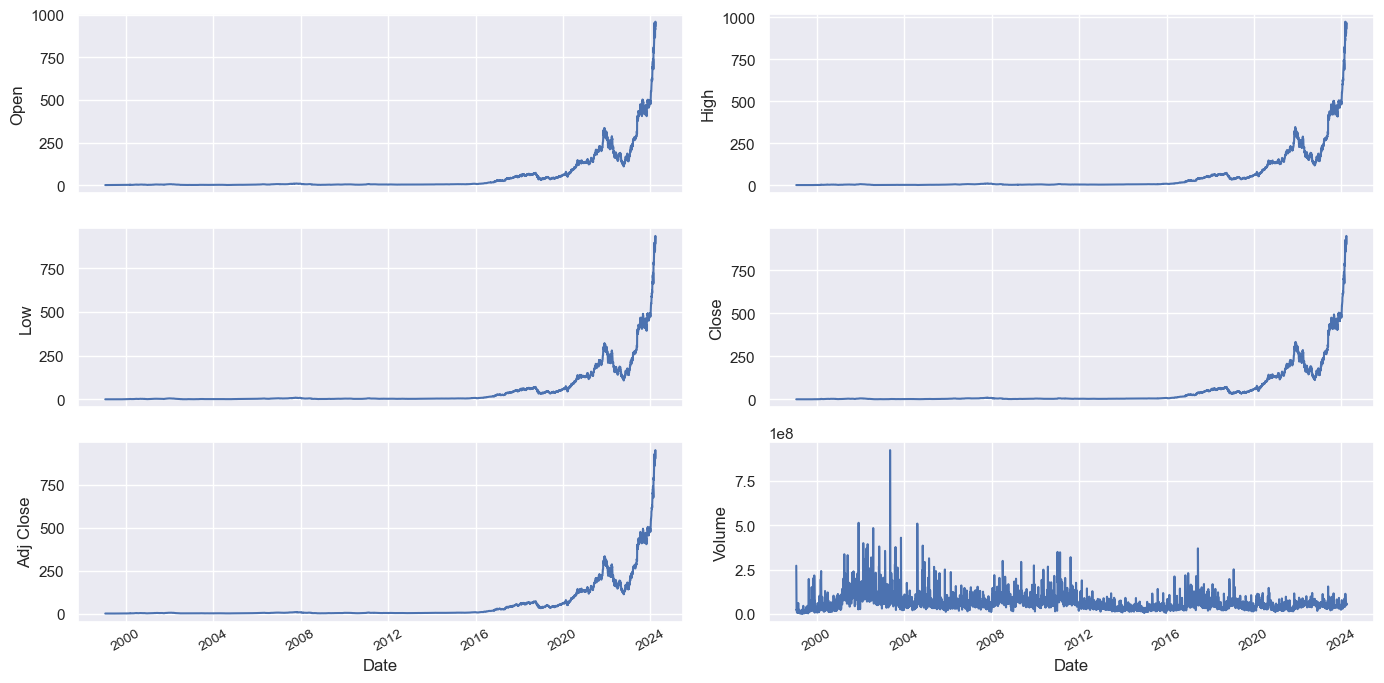

In [5]:
def data_plot(df):
	df_plot = df.copy()

	ncols = 2
	nrows = int(round(df_plot.shape[1] / ncols, 0))

	fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
						sharex=True, figsize=(14, 7))
	for i, ax in enumerate(fig.axes):
		sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
		ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
		ax.xaxis.set_major_locator(mdates.AutoDateLocator())
	fig.tight_layout()
	plt.show()

data_plot(df)

### Split into test and train datasets

We follow the common practice of splitting the data into training and testing set. We calculate the length of the training datasets and print their respective shapes to confirm the split. Generally, the split is 80:20 for training and test set.

Note, we can't split randomly like we do with other datasets because the data is sequential.  Usually the first 80% of the data is for training and the last 20% is for testing / validation.

In [6]:
# Train-Test Split 
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(5069, 1) (1267, 1)


### Prepare Training and Testing Datasets

Here, we are choosing the feature (‘Open’ prices), reshaping it into the necessary 2D format, and validating the resulting shape to make sure it matches the anticipated format for model input, this method prepares the training data for use in a neural network.

(We're extracting the column with 'Open' prices in each dataset and we want it to have shape (L,1) instead of (L))

In [7]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape


(5069, 1)

In [8]:
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(1267, 1)

### Normalization
We have apply Min-Max scaling which is a standard preprocessing step in machine learning and time series analysis, to the datasets. It adjusts the values to be between [0, 1], allowing neural networks and other models to converge more quickly and function better.

Here we're applying separate transforms to the training and testing data so each set will have a minimum of 0 and a maximum of 1.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(f'Min of training data before scaling: {min(dataset_train)[0]:0.3f}, Max:  {max(dataset_train)[0]:0.3f}')
print(f'Min of training data after scaling: {min(scaled_train)[0]}, Max:  {max(scaled_train)[0]}')

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(f'Min of testing data before scaling: {min(dataset_test)[0]:0.3f}, Max:  {max(dataset_test)[0]:0.3f}')
print(f'Min of testing data after scaling: {min(scaled_test)[0]}, Max:  {max(scaled_test)[0]}')

Min of training data before scaling: 0.349, Max:  72.330
Min of training data after scaling: 0.0, Max:  1.0
Min of testing data before scaling: 33.978, Max:  958.510
Min of testing data after scaling: 0.0, Max:  0.9999999999999999


### Transforming the data into sequences

This bit is from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

We want to use a sliding window of data to predict what happens on the next day.  For example, we might use data from M,T,W to predict H and data from T, W, H, to predict F, etc. 

The more complicated problem is how do you want the network to predict the time series. Usually time series prediction is done on a window. That is, given data from time $t-w$ to time $t$, you are asked to predict for time $t+1$  (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the *look back period*.

On a long enough time series, multiple overlapping window can be created. It is convenient to create a function to generate a dataset of fixed window from a time series. Since the data is going to be used in a PyTorch model, the output dataset should be in PyTorch tensors:

In [10]:
def create_sequences(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float(), torch.tensor(y).float()

This function is designed to apply windows on the time series. It is assumed to predict for one time step into the immediate future. It is designed to convert a time series into a tensor of dimensions (window sample, time steps, features). A time series of $L$ time steps can produce roughly $L$ windows (because a window can start from any time step as long as the window does not go beyond the boundary of the time series). Within one window, there are multiple consecutive time steps of values. In each time step, there can be multiple features. In this dataset, there is only one.

It is intentional to produce the “feature” and the “target” the same shape: For a window of three time steps, the “feature” is the time series from $t$ to $t+2$ and the target is from $t+1$ to $t+3$  What we are interested is $t+3$ but the information of $t+1$ to $t+2$ is useful to training.

Note that the input time series is a 2D array and the output from the create_sequences() function will be a 3D tensors.

For the training sequences for this problem we'll use a lookback of 50 days and 30 days for the test data.

In [11]:
X_train, y_train = create_sequences(scaled_train, lookback=50)
X_test, y_test = create_sequences(scaled_test, lookback=30)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5019, 50, 1]) torch.Size([5019, 50, 1])
torch.Size([1237, 30, 1]) torch.Size([1237, 30, 1])


/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_88955/1251139245.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X).float(), torch.tensor(y).float()


Now create data loaders that will load batches of 16 sequences:

In [12]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Step 4: Define LSTM class model
Now, we defined a PyTorch network using LSTM architecture. The class consist of LSTM layer and linear layer. In `LSTMModel` class, we initialized parameters:

* `input_size` : number of features in the input data at each time step
* `hidden_size` : hidden units in LSTM layer
* `num_layers` : number of LSTM layers
* `batch_first= True`: input data will have the batch size as the first dimension

Note 

In [13]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out

We aren't using embeddings here, so each value in the sequence is treated as 1D tensor of length 1 (for the characters we embedded them as 1D tensors of length 64).  So here we use `input_size = 1`.  We'll take the whole sequence of hidden states and use a liner layer to map that to a single number

## Step 5 Model Training and Evaluation

In [14]:
input_size = 1
num_layers = 2
hidden_size = 32
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers)

loss_func = torch.nn.MSELoss(reduction='mean')

metrics = {
    'MAE': MeanAbsoluteError(),
}

forecast_df = train_model(model, loss_func,
                       epochs = 3,
                       train_loader = train_loader,
                       val_loader = test_loader,
                       metrics = metrics
                      )

Epoch 3/3, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_MAE  train_loss  val_MAE  val_loss     Time    LR
     1   0.046669    0.011563 0.021344  0.001993 5.435250 0.001
     2   0.010389    0.001193 0.014728  0.001019 4.799269 0.001
     3   0.006616    0.000520 0.009518  0.000410 4.808338 0.001


`Trainer.fit` stopped: `max_epochs=3` reached.


### Visualize the training

<Axes: xlabel='Epoch', ylabel='train_loss'>

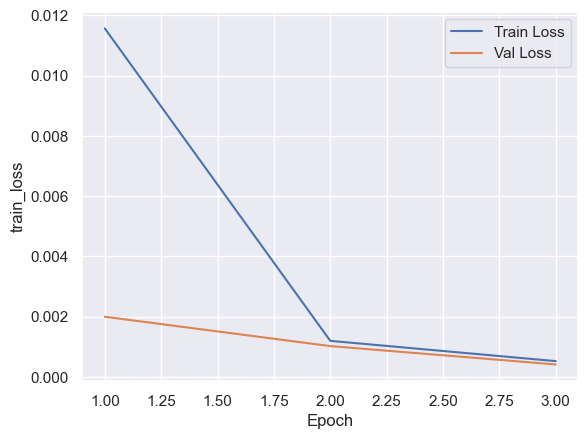

In [15]:
sns.lineplot(x='Epoch', y='train_loss', data = forecast_df, label='Train Loss')
sns.lineplot(x='Epoch', y='val_loss', data = forecast_df, label='Val Loss')

## Step 6: Forecasting

We'll consider the last 60 opening prices for our stock.  Starting from the first 30 opening prices in that window, we'll do a rolling forecast to try to predict the last 30 days.

In [19]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().numpy()

# Use the sequence ending 30 days ago to see if we can predict the next 30 days
historical_data = sequence_to_plot[-30]
tmp = historical_data

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        # Use the model to predict the next value
        output = model(historical_data_tensor).numpy()
        predicted_value = output[0,0]
        
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
        
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value[0]


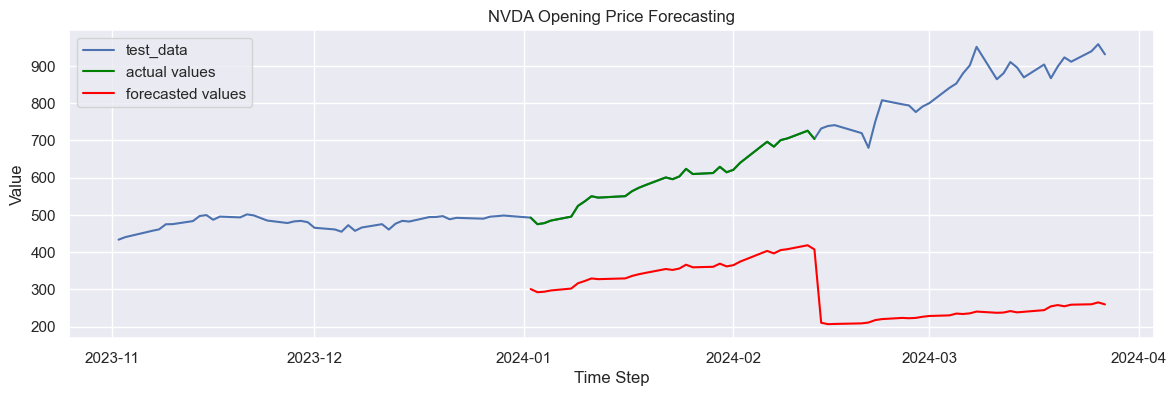

In [21]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 


#Test data
plt.plot(test_data.index[-100:], test_data.Open[-100:], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-30], axis=0)).flatten() 

#the historical data used as input for forecasting
plt.plot(test_data.index[-60:-30], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(test_data.index[-60:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title(f'{stock_ticker} Opening Price Forecasting')
plt.grid(True)


In [ ]:

# Define the number of future time steps to forecast
num_forecast_steps = 30
 
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().numpy()
 
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value[0]
 
         
# Generate futute dates
last_date = test_data.index[-1]
 
# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

In [ ]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 


#Test data
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
